In [50]:
# Importing deep learning 
from ultralytics import YOLO

# Other functionlaities 
import os 
import pandas as pd 
import numpy as np 
import math 

# Computer vision libs
import cv2 
import exifread
from exif import Image
from PIL import Image as PILImage

# Ploting 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import folium

In [51]:
def get_relative_altidute(img_path: str) -> float:
    """
    Descrption
    -----------
    The function extracts reltaive height from image metadata.

    Parameters
    ----------
    :param image_path : Path to the image

    Returns
    ----------
    :return: Relative height of the image
    """
    # Set default altitude to 0
    altitude = 0

    # Open the image using PIL
    with PILImage.open(img_path) as img:
        # Extract the XMP metadata
        try:
            # Get the XMP metadata from the image
            xmp = img.getxmp()
            # Get relative height from the XMP metadata
            altitude = xmp["xmpmeta"]["RDF"]["Description"]["RelativeAltitude"]
            # Convert the altitude to a float
            altitude = float(altitude)
        except Exception as e:
            print(f"Error extracting XMP metadata from image: {e}")

    # Extract the altitude value
    return altitude

In [52]:
# Loading the trained model 
model = YOLO('../ml_models/version_1.pt')

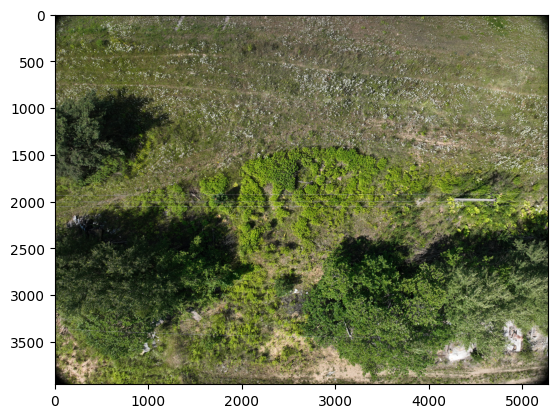

In [ ]:
# Defining the path to the image 
path_to_img = 'input/test_image_4.JPG'
base_name = os.path.basename(path_to_img)

# Reading and ploting the image 
img = cv2.imread(path_to_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Predicting pixels 

Once the model is loaded, we can extract the segments using the model object we just loaded. 

In [54]:
# Applying the model 
results = model(path_to_img)


image 1/1 c:\Users\Admin\projects\sosnovski-identifier\notebooks\input\test_image_3.JPG: 480x640 (no detections), 274.9ms
Speed: 4.5ms preprocess, 274.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


In [55]:
# Extracting the image shape 
img_w, img_h = img.shape[1], img.shape[0]

# Extracting the segments 
segments = results[0].masks.xyn
print(f"Number of segments: {len(segments)}")

AttributeError: 'NoneType' object has no attribute 'xyn'

The above `segments` object is a list containing each found patch of the sosnovski plant. The coordinates are normalized to the original image size. 

An example patch is shown below. 

```python
[
    array([[   0.009375,      0.2375],
        [   0.009375,     0.26875],
        [   0.023438,     0.26875],
        [   0.023438,      0.2625],
        [      0.025,     0.26042],
        [      0.025,     0.25833],
        [   0.026563,     0.25625],
        [   0.032812,     0.25625],
        [   0.032812,      0.2375]], dtype=float32)
]
```

The first coordinate is the x-axis and the second coordinate is the y-axis. To plot on the image, we need to multiply the coordinates by the original image size. 

In [ ]:
# Converting to coordinates in pixels on the given image
segments_pixels = []
for segment in segments:
    segment_pixels = [(x * img_w, y * img_h) for x, y in segment]
    segments_pixels.append(segment_pixels)

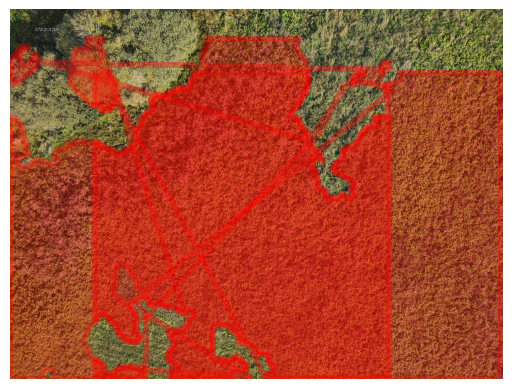

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(img)

# Create and add a Polygon patch for each segment with red fill and border
for segment in segments_pixels:
    # Setting facecolor to red fills the polygon, and alpha adds transparency
    polygon = patches.Polygon(segment, closed=True, edgecolor='red', facecolor='red', linewidth=4, alpha=0.35)
    ax.add_patch(polygon)

plt.axis('off')
plt.show()

# Prediction to GPS conversion 

To get all the exif information, please visit: https://exif.tools/

In [ ]:
# Extracting the function to extract the focal length
def extract_focal_length(file_path):
    # Open the image file for reading in binary mode
    with open(file_path, 'rb') as f:
        # Read the EXIF data
        tags = Image(f.read())
        
        # Check if the image has EXIF data
        if not tags.has_exif:
            print("No EXIF data found in the image.")
            return None

        # Check if GPSInfo tag is present
        if 'focal_length' in dir(tags):
            # Extract latitude, longitude, and altitude
            focal_length = tags.focal_length

            return float(focal_length)
        else:
            print("Focal length not found in the metadata.")
            return None

In [ ]:
focal_length = extract_focal_length(path_to_img)
print(f"The focal length is: {focal_length}mm")

The focal length is: 4.5mm


In [ ]:
def extract_gps_coordinates(file_path):
    # Open the image file for reading in binary mode
    with open(file_path, 'rb') as f:
        # Read the EXIF data
        tags = exifread.process_file(f)

        # Check if GPSInfo tag is present
        relative_altitude = 0
        if 'GPS GPSLatitude' in tags and 'GPS GPSLongitude' in tags and 'GPS GPSAltitude' in tags:
            # Extract latitude, longitude, and altitude
            latitude = tags['GPS GPSLatitude'].values
            longitude = tags['GPS GPSLongitude'].values
            altitude = tags['GPS GPSAltitude'].values

            # Getting the relative altitude
            relative_altitude = get_relative_altidute(file_path)

            # Convert coordinates to decimal format
            latitude_decimal = latitude[0] + latitude[1] / 60 + latitude[2] / 3600
            longitude_decimal = longitude[0] + longitude[1] / 60 + longitude[2] / 3600

            # 
            return float(latitude_decimal), float(longitude_decimal), float(altitude[0]), float(relative_altitude)
        else:
            print("GPS information not found in the metadata.")
            return None, None, None, None

In [ ]:
# Extracting the metadata
latitude, longitude, altitude, relative_altitude = extract_gps_coordinates(path_to_img)
print(f"The center coords are: {latitude}, {longitude}; Altitude {altitude}m; Relative Altitude {relative_altitude}m")

The center coords are: 55.02007211111111, 25.407351972222223; Altitude 256.848m; Relative Altitude 49.2m


In [ ]:
# Defining the camera properties (in mm)
# For the DJI Mavic 2 please visti: https://leapingwing.co.uk/gsd-calculator/
sensor_width = 6.4
sensor_height = 4.8

In [ ]:
def extract_image_gimbal_info(file_path):
    """
    Extracts the image roll, yaw and pitch parameters
    """
    # Open the image file for reading in binary mode
    with open(file_path, 'rb') as f:
        # Read the EXIF data
        tags = exifread.process_file(f)

        # Check if GPSInfo tag is present
        if 'XMP Camera:GimbalRollDegree' in tags and 'XMP Camera:GimbalYawDegree' in tags and 'XMP Camera:GimbalPitchDegree' in tags:
            # Extract latitude, longitude, and altitude
            roll = tags['XMP Camera:GimbalRollDegree'].values[0]
            yaw = tags['XMP Camera:GimbalYawDegree'].values[0]
            pitch = tags['XMP Camera:GimbalPitchDegree'].values[0]

            return float(roll), float(yaw), float(pitch)
        else:
            print("Gimbal information not found in the metadata.")
            return None, None, None

In [ ]:
gimbal_roll, gimal_yaw, gimbal_pitch = extract_image_gimbal_info(path_to_img)

Gimbal information not found in the metadata.


In [ ]:
# Hard saving the values for the example image
gimbal_roll = 0
gimbal_yaw = -119.10
gimbal_pitch = -89.9

In [ ]:
# Defining the function that calculates the diff in pixels to meters
# GSD - Ground Sampling Distance
def calculate_gsd(
        height_from_ground, 
        image_width, 
        image_height, 
        sensor_width, 
        sensor_height, 
        focal_length
        ):
    """
    Function that calculates the GSD (Ground Sampling Distance) from pixels to meters

    Args:
        height_from_ground (float): Height from ground in meters
        image_width (int): Image width in pixels
        image_height (int): Image height in pixels
        sensor_width (float): Sensor width in mm
        sensor_height (float): Sensor height in mm
        focal_length (float): Focal length in mm

    Returns:
        gsd_h (float): Horizontal GSD in meters
        gsd_v (float): Vertical GSD in meters
    """
    # Calculating the horizontal and vertical GSD
    gsd_h = (height_from_ground * sensor_width) / (focal_length * image_width)
    gsd_v = (height_from_ground * sensor_height) / (focal_length * image_height)
    # Returning the average GSD
    return gsd_h, gsd_v

In [ ]:
# Calculating the diff in horizontal and vertical pixels to meters
gsd_h, gsd_v = calculate_gsd(
    relative_altitude,
    img.shape[1],
    img.shape[0],
    sensor_width, 
    sensor_height, 
    focal_length
    )

print(f"1 pixel in horizontal direction is {gsd_h} meters")
print(f"1 pixel in vertical direction is {gsd_v} meters")

1 pixel in horizontal direction is 0.008746666666666668 meters
1 pixel in vertical direction is 0.008746666666666666 meters


In [ ]:
def pixel_to_gps_with_gimbal(x, y, width, height, lat_center, lon_center, gsd_h, gsd_v, yaw, pitch, roll, altitude):
    """
    Convert pixel coordinates to GPS coordinates considering gimbal orientation.
    
    Parameters:
    x, y          : Pixel coordinates
    width, height : Dimensions of the image
    lat_center    : Latitude of the center point (degrees)
    lon_center    : Longitude of the center point (degrees)
    gsd_h, gsd_v  : Horizontal and vertical GSD (meters/pixel)
    yaw, pitch, roll : Gimbal orientation (degrees)
    altitude      : Camera altitude (meters)
    
    Returns:
    (lat, lon) : GPS coordinates of the pixel
    """
    # Convert gimbal angles to radians
    yaw = math.radians(yaw)
    pitch = math.radians(pitch)
    roll = math.radians(roll)

    # Rotation matrices
    R_yaw = np.array([
        [math.cos(yaw), -math.sin(yaw), 0],
        [math.sin(yaw), math.cos(yaw), 0],
        [0, 0, 1]
    ])

    R_pitch = np.array([
        [math.cos(pitch), 0, math.sin(pitch)],
        [0, 1, 0],
        [-math.sin(pitch), 0, math.cos(pitch)]
    ])

    R_roll = np.array([
        [1, 0, 0],
        [0, math.cos(roll), -math.sin(roll)],
        [0, math.sin(roll), math.cos(roll)]
    ])

    # Combined rotation matrix
    R = R_yaw @ R_pitch @ R_roll

    # Offset from center in pixels
    dx = x - width / 2
    dy = y - height / 2

    # Real-world offsets in meters
    delta_x_real = dx * gsd_h
    delta_y_real = dy * gsd_v

    # Camera to world transformation
    ray_camera = np.array([delta_x_real, delta_y_real, altitude])
    ray_world = R @ ray_camera

    # Project onto ground plane (Z_w = 0)
    scale = altitude / ray_world[2]
    ground_offset = ray_world[:2] * scale

    # Convert offsets to GPS
    R_earth = 6371000  # Earth radius in meters
    delta_lat = ground_offset[1] / R_earth * (180 / math.pi)
    delta_lon = ground_offset[0] / (R_earth * math.cos(math.radians(lat_center))) * (180 / math.pi)

    # GPS coordinates
    lat = lat_center + delta_lat
    lon = lon_center + delta_lon

    return lat, lon

In [ ]:
def pixel_to_gps(x, y, width, height, lat_center, lon_center, gsd_h, gsd_v, altitude):
    """
    Convert pixel coordinates to GPS coordinates for a nadir (straight-down) view,
    without considering gimbal orientation.
    
    Parameters:
      x, y          : Pixel coordinates
      width, height : Dimensions of the image (in pixels)
      lat_center    : Latitude of the center point (degrees)
      lon_center    : Longitude of the center point (degrees)
      gsd_h, gsd_v  : Horizontal and vertical ground sample distance (meters/pixel)
      altitude      : Camera altitude (meters) (not used in this simple model,
                      since gsd is assumed to be pre-calculated based on altitude)
    
    Returns:
      (lat, lon) : GPS coordinates of the pixel
    """
    # Offset from the image center in pixels
    dx = x - width / 2
    dy = y - height / 2

    # Convert pixel offsets to real-world distances in meters.
    # Note: Depending on your coordinate system, you might need to flip the sign of dy.
    delta_x_m = dx * gsd_h   # east-west displacement (meters)
    delta_y_m = dy * gsd_v   # north-south displacement (meters)

    # Convert meter offsets to degrees.
    # The conversion is approximate (suitable for small displacements).
    R_earth = 6371000  # Earth radius in meters
    delta_lat = (delta_y_m / R_earth) * (180 / math.pi)
    delta_lon = (delta_x_m / (R_earth * math.cos(math.radians(lat_center)))) * (180 / math.pi)

    # Calculate the final GPS coordinates
    lat = lat_center + delta_lat
    lon = lon_center + delta_lon

    return lat, lon

In [ ]:
# Creating the gps coordinates
polygon_points = results[0].masks
gps_points = []
polygon_idx = 0
for mask in polygon_points:
    points = mask.xy[0]
    for point in points:
        gps_points.append(
            (
                polygon_idx,
                # pixel_to_gps_with_gimbal(
                #     point[0], 
                #     point[1], 
                #     img.shape[1], 
                #     img.shape[0], 
                #     latitude, 
                #     longitude, 
                #     gsd_h, 
                #     gsd_v, 
                #     gimbal_yaw, 
                #     gimbal_pitch, 
                #     gimbal_roll, 
                #     relative_altitude
                # )
                pixel_to_gps(
                    point[0], 
                    point[1], 
                    img.shape[1], 
                    img.shape[0], 
                    latitude, 
                    longitude, 
                    gsd_h, 
                    gsd_v, 
                    relative_altitude
                )
            )
        )
    polygon_idx += 1
    

In [ ]:
gps_points_df = pd.DataFrame(gps_points, columns=['polygon_idx', 'gps_coords'])
gps_points_df['lat'] = gps_points_df['gps_coords'].apply(lambda x: x[0])
gps_points_df['lon'] = gps_points_df['gps_coords'].apply(lambda x: x[1])
gps_points_df.drop(columns=['gps_coords'], inplace=True)

## Ploting the points on a map

In [ ]:
# Create a Folium map centered at the average coordinates
m = folium.Map(location=[
  54.74341588888889, 
  25.181317416666666  
], zoom_start=8)

# Loop over each polygon group
for polygon, group in gps_points_df.groupby('polygon_idx'):
    # Create a list of (lat, long) pairs
    points = list(zip(group['lat'], group['lon']))
    # Optionally, close the polygon by adding the first point at the end
    points.append(points[0])
    # Add the polygon to the map
    folium.Polygon(locations=points,
                   popup=f"Polygon {polygon}",
                   color='blue',
                   fill=True,
                   fill_color='cyan').add_to(m)

In [ ]:
m